## Kaggle Python public API for data collection : Notebook Classification TASK

In [1]:
DATA_PATH_KEYWORDS = '../data/search_keywords.csv'
DATA_PATH_NOTEBOOKS = '../data/'

Importing librairies

In [2]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import numpy as np

In [3]:
api = KaggleApi()
api.authenticate()

Read the file containing the search keywords used to retrieve notebooks 

In [13]:
keywords_df = pd.DataFrame(columns=['Category', 'Subcategory'])
keywords_df = pd.read_csv(DATA_PATH_KEYWORDS, sep=';') 
keywords_df

,subcategory,category
0,linear regression,regression
1,lasso regression,regression
2,randomforestregression,regression
3,ridge regression,regression
4,XGBRegressor,regression
...,...,...
89,sarsa,reinforcement learning
90,ddpg,reinforcement learning
91,qlearning,reinforcement learning
92,markov decision,reinforcement learning


The following function returns the category of a Notebook based on its subcategory

In [4]:
def search(sub,data):
    for i in data.index:
        if data.loc[i]['subcategory'] == sub:
            return data.loc[i]['category']

# List of notebooks

In [5]:
df = pd.DataFrame(columns=['title','subcategory','category'])

Building a notebook titles dataframe with category and subcategory

In [ ]:
for keyword in keywords_df['subcategory']:
    for i in range(1,11):
        try :
                kernels = api.kernels_list(search = keyword, page=i)
                for kernel in kernels:
                    df.loc[len(df)]=[kernel,keyword,search(keyword,keywords_df)]
        except Exception as e:
            print('Kaggle API exception :', kernel, 'Notebook not found')

In [13]:
df.head(10)

,title,subcategory,category
0,Linear Regression Tutorial,linear regression,regression
1,Car Price Prediction (Linear Regression - RFE),linear regression,regression
2,Multiple Linear Regression,linear regression,regression
3,Simple Linear Regression for Salary Data,linear regression,regression
4,Price analysis and Linear Regression,linear regression,regression
5,Linear Regression Project,linear regression,regression
6,PyTorch basics - Linear Regression from scratch,linear regression,regression
7,FIFA in depth analysis with Linear Regression,linear regression,regression
8,Sales Prediction (Simple Linear Regression),linear regression,regression
9,Linear Regression,linear regression,regression


Saving the dataframe to a .csv

In [ ]:
df.to_csv(DATA_PATH_NOTEBOOKS+'ntb_list.csv')

In [ ]:
means = (df.category.value_counts() / len(df)) * 100

meansdf = pd.DataFrame(columns=['category', 'means'])
meansdf.category = means.index
meansdf.means = means.values

meansdf

,category,means
0,nlp,31.588785
1,computer vision,22.565845
2,clustering,17.672048
3,regression,13.406967
4,classification,10.220901
5,reinforcement learning,4.392523


<AxesSubplot:xlabel='category', ylabel='means'>

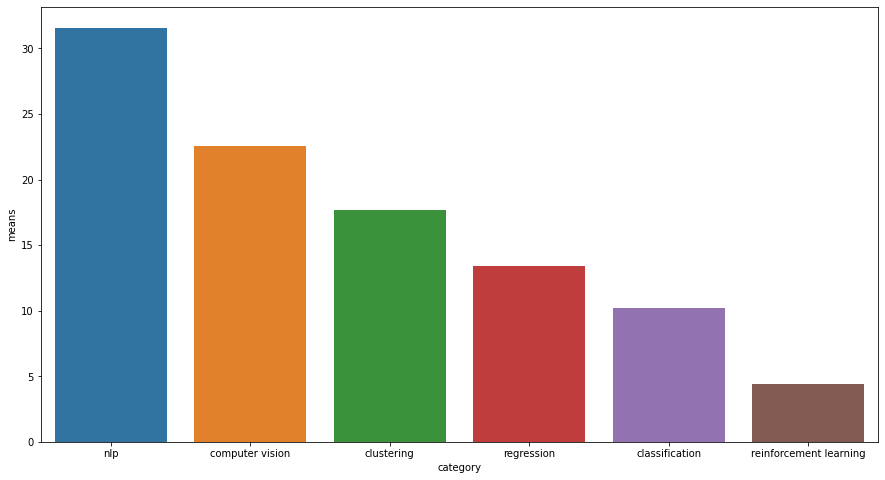

In [11]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))
sns.barplot(x='category', y='means', data=meansdf)


### Before collecting
- Delete duplicate notebooks : print duplicate categories => choose best category to keep
- Delete notebooks with non-english titles

In [4]:
df = pd.read_csv(DATA_PATH_NOTEBOOKS+'ntb_list.csv', sep=',', encoding='utf-8', index_col=0)
df.head()

,title,subcategory,category
0,Linear Regression Tutorial,linear regression,regression
1,Car Price Prediction (Linear Regression - RFE),linear regression,regression
2,Multiple Linear Regression,linear regression,regression
3,Simple Linear Regression for Salary Data,linear regression,regression
4,Price analysis and Linear Regression,linear regression,regression


In [5]:
df.shape

(11752, 3)

In [6]:
# a dict with duplicate titles and their respective positions in the df
duplicates = df[df.duplicated('title', keep=False)].groupby('title').groups

In [7]:
def flatten_list(l):
    return [item for sublist in l for item in sublist]

In [8]:
import collections

def to_be_dropped_indices(dictionary):
    to_be_dropped = [] # indices to be dropped from original df
    temp = []

    for k,v in dictionary.items():
        duplicates_df = df[df.index.isin(v.values)]
        
        # if the rows have the same category, they are all dropped except the last one
        if len(set(list(duplicates_df.category))) == 1:
            to_be_dropped.append(list(duplicates_df.index[:len(duplicates_df.category)-1]))

        else: 
            # drop least common category duplicates for a notebook
            dup_counter = collections.Counter(duplicates_df.category)
            most_common = dup_counter.most_common()[0][0]
            most_common_i = duplicates_df.index.where(duplicates_df.category == most_common).dropna()[0]

            to_be_dropped.append(duplicates_df.index.where(duplicates_df.index != most_common_i).dropna())

    return flatten_list(to_be_dropped)

Getting indices of rows to be dropped (duplicates)

In [9]:
to_be_dropped = to_be_dropped_indices(duplicates)
len(to_be_dropped), to_be_dropped[:10]

(2953, [8646, 7627, 9350, 6759, 9313, 10416, 2799, 2196.0, 9195.0, 9408.0])

Dropping duplicates

In [10]:
df_clean = df.copy()
df_clean.drop(to_be_dropped, inplace=True)
print(df_clean.shape)

(8798, 3)


#### Removing non-english titles

In [17]:
# tokenize keywords
def list_to_unique_words(list):
    unique_words = []
    for l in list:
        unique_words.append(str(l).lower().split())

    return flatten_list(unique_words)

Update the default *nltk* words list to add our categories and subcategories and other custom words that are domain specific to avoid them being removed

In [42]:
lower_categ = list_to_unique_words(list(keywords_df.category))
lower_subcateg = list_to_unique_words(list(keywords_df.subcategory))
custom_list = ['dataset', 'datasets', 'feature', 'transformer', 'transformers', 'using', 'detect', 'detecting', 'machine', 'intro', 'pca', 'connectx', 'xgboost', 'visualising', 'visualizing', 'gaussian', 'bayesian', 'score', 'scores', 'map', 'maps', 'ml', 'dl', 'algorithm', 'algorithms', 'feature', 'features']

In [72]:
import nltk
from langdetect import detect
from langdetect import detect_langs
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [43]:
# nltk.download('words')

words = set(nltk.corpus.words.words())

words.update(lower_categ)
words.update(lower_subcateg)
words.update(custom_list)

# exepected non-english indices : 353 1594 1640 1584 1664 4412 8273 11540 1081 1715 1642 4693 5320 7295 10615 11629

In [70]:
for row in df_clean.index:
    title = df_clean.loc[row, 'title']
    try:
        # print(df_clean.loc[row, 'title'])
        # title = "Chaii EDA&Baseline 実況"
        clean_title = " ".join(w for w in nltk.wordpunct_tokenize(title) \
                if w.lower() in words or not w.isalpha())


        
        if ((len(title.split()) - len(clean_title.split())) > 3) or len(clean_title.split()) == 0: print(row, title, '==', clean_title) # prints titles with low # of english words
    except Exception as e:
        print(e)

350 HousePricing  == 
353 3 Farklı Algoritma ile Ev Fiyatları Tahmini(Emlak) == 3 ( )
362 UsedCarPricePrediction == 
363 HeartDisease == 
390 emissionglobals == 
411 LOGISTICVSDECISIONTREEVSRANDOMFOREST == 
472 Jigsaw  == 
493 MSCI CITEseq Quickstart == 
746 petfinder == 
828 FitZee == 
832 BrentOilPricePrediction == 
880 SuperBowl Halftime shows == 
930 marshouse == 
1081 欠損値の対応から複数モデルによるBlending == 
1161 Trending YouTube Statistics Analysis Model wth PCR == Statistics Analysis Model
1162 lineerRegresyon == 
1210 Hitters == 
1248 EDA basico == 
1254 Trending YouTube Statistics Analysis Model wth PLS == Statistics Analysis Model
1283 StackingAndEnsembling == 
1286 Sagar == 
1303 Whole Pipeline | EDA + LGBM + XGB + StackingReg 📚 == Whole Pipeline | + + + 📚
1457 RAPIDS SVM on TReNDS Neuroimaging == on
1464 Hyperparamaters == 
1466 EDA of Rapids SVR | Actual vs Pred Comparison 👀 == of SVR | Actual Comparison 👀
1571 EDA & Basline Modeling - CommonLit Passages == & Modeling -
1584 Redes Neu

In [76]:
detect_langs('Method'), detect('Method')

([cy:0.9999978753840443], 'cy')

# Collecting notebooks by category

In [52]:
for keyword in keywords_df['subcategory']:
    for i in range(1,16):
        try :
                kernels = api.kernels_list(search = keyword, page=i)
                for kernel in kernels:
                        api.kernels_pull(kernel.ref, path = DATA_PATH_NOTEBOOKS + search(keyword,keywords_df))
        except Exception as e:
            print('Kaggle API exception : ', kernel.ref, 'Notebook not found')

Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook not found
Kaggle API exception : Notebook no

In [21]:
import re
s = '<a class=""anchor"" id="2"></a>hkdfv'
result = re.search(r'<a class=""anchor""(.*?)</a>', s).group(1)
result = re.sub(r'<a class=""anchor"".*?</a>'," ",s)
result

' hkdfv'